In [1]:
from typing import Annotated
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition
from langgraph.graph.message import add_messages # A reducer function
from langchain_openai import ChatOpenAI, AzureChatOpenAI
from pydantic import BaseModel
from dotenv import load_dotenv
from typing import Annotated, Optional, Any
from databricks_langchain import ChatDatabricks
import os
from client import AzureAIClient
from IPython.display import Image, display
import gradio as gr
from langgraph.checkpoint.memory import MemorySaver
from pydantic import BaseModel, Field
import sqlite3
from langgraph.checkpoint.sqlite import SqliteSaver
from langgraph.checkpoint.sqlite.aio import AsyncSqliteSaver
import aiosqlite
from agent_tools import get_agent_tools, get_playwright_tools

from langchain_core.messages import AIMessage, HumanMessage, SystemMessage
import uuid

load_dotenv(override=True)

c:\Users\edan\repos\personal_projects\AI\Agentic_AI_Projects\langgraph_sidekick\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


True

In [2]:
import nest_asyncio
nest_asyncio.apply()

In [3]:
# Create a simple state
class State(BaseModel):
    messages: Annotated[list, add_messages]


# Get llms
llm_db = ChatDatabricks(endpoint="databricks-claude-3-7-sonnet", max_tokens=1000)

llm_az = AzureChatOpenAI(
    api_version="2024-12-01-preview",
    azure_ad_token_provider=AzureAIClient().token_provider,
    azure_deployment="gpt-4o"
)

2025-07-06 18:46:56.393 | SUCCESS  | client:_get_token_provider:41 - Successfully initialized Azure Credentials!!


In [4]:
# Get the tools
tools_list = await get_agent_tools()
playwright_tools, browser, playwright = await get_playwright_tools()

agent_tools = tools_list + playwright_tools
print(agent_tools)

# Give the llm the tools
llm_with_tools = llm_az.bind_tools(agent_tools)

[Tool(name='google_serper_search_tool', description='Useful for when you need more information from an online search', func=<bound method GoogleSerperAPIWrapper.run of GoogleSerperAPIWrapper(k=10, gl='us', hl='en', type='search', result_key_for_type={'news': 'news', 'places': 'places', 'images': 'images', 'search': 'organic'}, tbs=None, serper_api_key='9ebe684e10f6f741b31dd52c20ed19bbdd175519', aiosession=None)>), Tool(name='push_notification_tool', description='Useful for sending push notifications to the user', func=<function push at 0x000001F2048A0360>), Tool(name='send_email_tool', description='Useful for sending emails to the user', func=<function send_email at 0x000001F2047FD6C0>), ClickTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=138.0.7204.23>), NavigateTool(async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-pla

In [5]:
for tool in agent_tools:
    print(f"Tool Name: {tool.name} == {tool}")

# Drop the serper tool for testing the playwright tool
agent_tools = [tool for tool in agent_tools if tool.name != "google_serper_search_tool"]
print("\n\n", agent_tools)
for tool in agent_tools:
    print(f"Tool Name: {tool.name} == {tool}")

Tool Name: google_serper_search_tool == name='google_serper_search_tool' description='Useful for when you need more information from an online search' func=<bound method GoogleSerperAPIWrapper.run of GoogleSerperAPIWrapper(k=10, gl='us', hl='en', type='search', result_key_for_type={'news': 'news', 'places': 'places', 'images': 'images', 'search': 'organic'}, tbs=None, serper_api_key='9ebe684e10f6f741b31dd52c20ed19bbdd175519', aiosession=None)>
Tool Name: push_notification_tool == name='push_notification_tool' description='Useful for sending push notifications to the user' func=<function push at 0x000001F2048A0360>
Tool Name: send_email_tool == name='send_email_tool' description='Useful for sending emails to the user' func=<function send_email at 0x000001F2047FD6C0>
Tool Name: click_element == async_browser=<Browser type=<BrowserType name=chromium executable_path=C:\Users\edan\AppData\Local\ms-playwright\chromium-1179\chrome-win\chrome.exe> version=138.0.7204.23>
Tool Name: navigate_bro

In [6]:
# Memory database
db_path="memory_db/sqlite_memory.db"
conn = sqlite3.connect(db_path, check_same_thread=False)

async def setup_async_db():
    async_conn = await aiosqlite.connect(db_path)
    return async_conn

async_conn = await setup_async_db()

# sql_memory = SqliteSaver(conn)
sql_memory = AsyncSqliteSaver(async_conn)

# memory = MemorySaver()

In [ ]:
# Chat function
def chat(state: State) -> State:
    response = llm_with_tools.invoke(state.messages)
    new_state = State(messages=[response])
    return new_state

### Build Graph

In [ ]:
graph_builder = StateGraph(state_schema=State)

graph_builder.add_edge(START, "chat")
graph_builder.add_node("chat", chat)
graph_builder.add_node("tools", ToolNode(tools=agent_tools))

graph_builder.add_conditional_edges("chat", tools_condition, "tools")
graph_builder.add_edge("tools", "chat")

graph = graph_builder.compile(checkpointer=sql_memory)
# graph = graph_builder.compile(checkpointer=memory)
display(Image(graph.get_graph().draw_mermaid_png()))

### Create gradio chat function

In [ ]:
config = {"configurable": {"thread_id": "2"}}

async def gradio_chat(user_input: str, history):
    state = State(messages=[{"role": "user", "content": user_input}])
    response = await graph.ainvoke(state, config=config) # Config sets the thread to use in memory
    print(response)

    return response["messages"][-1].content

In [ ]:
# Chat interface
gr.ChatInterface(gradio_chat, type="messages").launch()

### Adding another Evaluator agent into the mix with some structured outputs

In [7]:
class EvaluatorOutput(BaseModel):
    feedback: str = Field(description="Feedback on the assistant's response")
    success_criteria_met: bool = Field(description="Whether the success criteria have been met")
    user_input_needed: bool = Field(description="True if more input is needed from the user, or clarification is required, or the assistant is stuck")

In [8]:
# Make  a new state
class State(BaseModel):
    messages: Annotated[list, add_messages]
    success_criteria: str
    feedback_on_work: Optional[str]
    success_criteria_met: bool
    user_input_needed: bool

In [9]:
evaluator_llm = llm_db.with_structured_output(EvaluatorOutput)

In [10]:
# First assistant - aka - worker_agent 
def agent_worker(state: State) -> State:
    system_message = f"""You are a helpful assistant that can use tools to complete tasks.
    You keep working on a task until either you have a question or clarification for the user, or the success criteria is met.
    This is the success criteria:
    {state.success_criteria}
    You should reply either with a question for the user about this assignment, or with your final response.
    If you have a question for the user, you need to reply by clearly stating your question. 
    An example Quenstion might be: Question: please clarify whether you want a summary or a detailed answer

    If you've finished, reply with the final answer, and don't ask a question; simply reply with the answer.
    """
        
    if state.feedback_on_work:
        system_message += f"""
        Previously you thought you completed the assignment, but your reply was rejected because the success criteria was not met.
        Here is the feedback on why this was rejected:
        {state.feedback_on_work}
        With this feedback, please continue the assignment, ensuring that you meet the success criteria or have a question for the user."""
    
    # Add in the system message
    found_system_message = False
    # messages = state["messages"]
    messages = state.messages
    for message in messages:
        if isinstance(message, SystemMessage):
            message.content = system_message
            found_system_message = True
    
    if not found_system_message:
        messages = [SystemMessage(content=system_message)] + messages
    
    # Invoke the LLM with tools
    response = llm_with_tools.invoke(messages)
    new_state = state.model_copy(update={"messages": [response]})
    # Return updated state
    return new_state

In [11]:
# agent_worker routing - conditional edge that decides whether to route to the evaluator or to using tools
def agent_worker_router(state: State) -> str:
    last_message = state.messages[-1]
    print(f"Last message type: {type(last_message)}")
    print(f"Last message content: {last_message}")
    
    if hasattr(last_message, "tool_calls") and last_message.tool_calls:
        return "tools"
    else:
        return "agent_evaluator"

In [12]:
# Convert the messages into a more followable format for the evalutor agent
def format_converstation(messages: list[Any]) -> str:
    convo = "Conversation history:\n\n"
    for msg in messages:
        if isinstance(msg, HumanMessage):
            convo += f"User: {msg.content}\n"
        elif isinstance(msg, AIMessage):
            text = msg.content or "[Tools used]"
            convo += f"Assistant: {text}\n"
    return convo

In [13]:
# Second assistant - aka - evaluator_agent
def agent_evaluator(state: State) -> State:
    last_response = state.messages[-1].content

    system_message = """You are an evaluator that determines if a task has been completed successfully by an Assistant.
    Assess the Assistant's last response based on the given criteria. Respond with your feedback, and with your decision on whether the success criteria has been met,
    and whether more input is needed from the user."""

    user_message = f"""You are evaluating a conversation between the User and Assistant. You decide what action to take based on the last response from the Assistant.
    Here is the conversation history:
    {format_converstation(state.messages)}

    The success criteria for this assignment is:
    {state.success_criteria}

    The final response from the Assistant is:
    {last_response}

    Respond with your feedback, and decide if the success criteria is met by this response.
    Also, decide if more user input is required, either because the assistant has a question, needs clarification, or seems to be stuck and unable to answer without help.
    """

    if state.feedback_on_work:
        user_message += f"Also, note that in a prior attempt from the Assistant, you provided this feedback: {state.feedback_on_work}\n"
        user_message += "If you're seeing the Assistant repeating the same mistakes, then consider responding that user input is required."
    
    evaluator_messages  = [SystemMessage(content=system_message), HumanMessage(content=user_message)]

    evaluator_response = evaluator_llm.invoke(evaluator_messages)

    new_state = State(
        messages=[{"role": "assistant", "content": f"Evaluator Feedback on this answer: {evaluator_response.feedback}"}],
        feedback_on_work=evaluator_response.feedback,
        success_criteria_met=evaluator_response.success_criteria_met,
        user_input_needed=evaluator_response.user_input_needed,
        success_criteria=state.success_criteria,
        )
    
    return new_state


In [14]:
# Routing the agent evaluator for the edges

def route_based_on_evaluation(state: State) -> str:
    if state.success_criteria_met or state.user_input_needed:
        return "END"
    else:
        return "agent_worker"


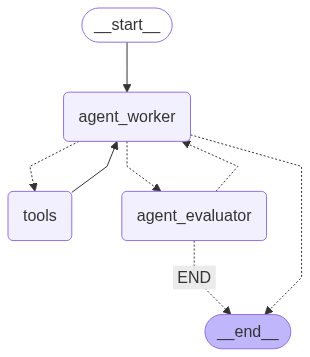

In [15]:
memory = MemorySaver()

## WE are all set make the graph
graph_builder = StateGraph(state_schema=State)

# Nodes
graph_builder.add_edge(START, "agent_worker")
graph_builder.add_node("tools", ToolNode(tools=agent_tools))
graph_builder.add_node("agent_worker", agent_worker)
graph_builder.add_node("agent_evaluator", agent_evaluator)

# Edges 
graph_builder.add_conditional_edges("agent_worker", agent_worker_router, {"tools": "tools", "agent_evaluator": "agent_evaluator"})
graph_builder.add_edge("tools", "agent_worker")
graph_builder.add_conditional_edges("agent_evaluator", route_based_on_evaluation, {"agent_worker": "agent_worker", "END": END})

# Compile the graph
# graph = graph_builder.compile(checkpointer=sql_memory)
graph = graph_builder.compile(checkpointer=memory)

# Display the graph
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
### Final Step Gradio inplementaion

def make_thread_id() -> str:
    return str(uuid.uuid4())


async def process_message(message, success_criteria, history, thread):

    config = {"configurable": {"thread_id": thread}}

    # state = {
    #     "messages": message,
    #     "success_criteria": success_criteria,
    #     "feedback_on_work": None,
    #     "success_criteria_met": False,
    #     "user_input_needed": False
    # }
    
    state = State(
        messages=[{"role": "user", "content": message}],
        success_criteria=success_criteria,
        feedback_on_work=None,
        success_criteria_met=False,
        user_input_needed=False
    )

    result = await graph.ainvoke(state, config=config)
    user = {"role": "user", "content": message}
    reply = {"role": "assistant", "content": result["messages"][-2].content}
    feedback = {"role": "assistant", "content": result["messages"][-1].content}
    return history + [user, reply, feedback]

async def reset():
    return "", "", None, make_thread_id()

In [17]:
# Put it all together in a gradio interface
with gr.Blocks(theme=gr.themes.Default(primary_hue="emerald")) as demo:
    gr.Markdown("## Sidekick Personal Co-worker")
    thread = gr.State(make_thread_id())
    
    with gr.Row():
        chatbot = gr.Chatbot(label="Sidekick", height=300, type="messages")
    with gr.Group():
        with gr.Row():
            message = gr.Textbox(show_label=False, placeholder="Your request to your sidekick")
        with gr.Row():
            success_criteria = gr.Textbox(show_label=False, placeholder="What are your success critiera?")
    with gr.Row():
        reset_button = gr.Button("Reset", variant="stop")
        go_button = gr.Button("Go!", variant="primary")
    message.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    success_criteria.submit(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    go_button.click(process_message, [message, success_criteria, chatbot, thread], [chatbot])
    reset_button.click(reset, [], [message, success_criteria, chatbot, thread])

    
demo.launch()

* Running on local URL:  http://127.0.0.1:7860
* To create a public link, set `share=True` in `launch()`.


Last message type: <class 'langchain_core.messages.ai.AIMessage'>
Last message content: content='' additional_kwargs={'tool_calls': [{'id': 'call_WTjUyaPT2dPmIhLmHdxdoMNB', 'function': {'arguments': '{"__arg1":"Hi"}', 'name': 'push_notification_tool'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 482, 'total_tokens': 500, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_ee1d74bde0', 'id': 'chatcmpl-BqKwJGX9QlNg48lP4mtMg0zmjOl5H', 'service_tier': None, 'prompt_filter_results': [{'prompt_index': 0, 'content_filter_results': {'hate': {'filtered': False, 'severity': 'safe'}, 'jailbreak': {'filtered': False, 'detected': False}, 'self_harm': {'filtered': False, 'severity': 'safe'}, 'sexual': {'filtered': Fal